In [1]:
from pathlib import Path
import pickle

In [2]:
import numpy as np
import pandas as pd

In [3]:
import gpflow
import tensorflow as tf

In [4]:
from gpflow.utilities import print_summary
gpflow.config.set_default_summary_fmt("notebook")

In [5]:
import casadi as cs

In [6]:
import matplotlib.pyplot as plt

In [7]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 6)

## GP model

In [8]:
size = 500

In [9]:
X = np.linspace(-2, 2, num = size)
# x^4 + 3*sin(x)
Y =3 * X ** 2
Y = X**4 + 3*np.sin(X)

In [10]:
df_func = pd.DataFrame({
    'X': X,
    'Y': Y
})

In [11]:
n_sampl = 55

In [12]:
df_sampled = df_func.sample(n_sampl)
X_sampled = df_sampled['X'].to_numpy().reshape(-1, 1)

In [13]:
Y_sampled = df_sampled['Y'].to_numpy().reshape(-1, 1)

# Add noise to the output
mean, var = 0, 0.25
noise = np.random.normal(mean, var, size = Y_sampled.shape)

Y_sampled = Y_sampled + noise

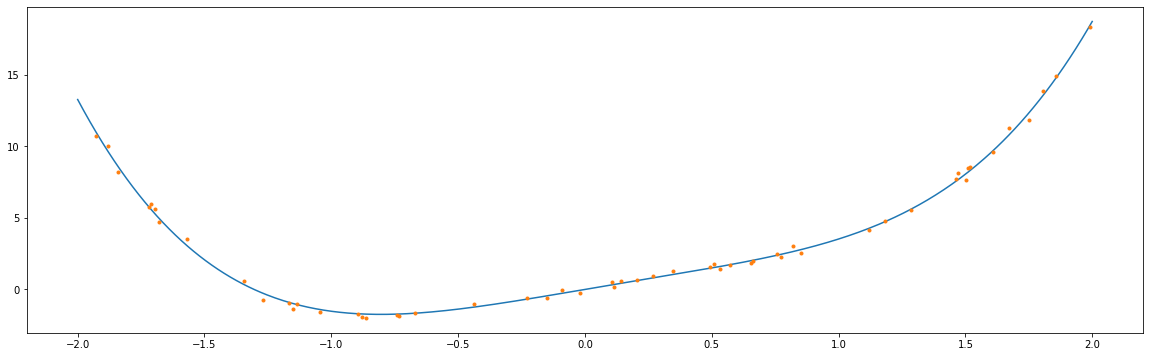

In [14]:
plt.figure()
plt.plot(X, Y)
plt.plot(X_sampled, Y_sampled, '.')
plt.show()

In [15]:
variance = tf.math.reduce_variance(X_sampled)

In [16]:
k = gpflow.kernels.SquaredExponential(variance = variance, lengthscales = 0.5)

In [17]:
print_summary(k)

name,class,transform,prior,trainable,shape,dtype,value
SquaredExponential.variance,Parameter,Softplus,,True,(),float64,1.39191
SquaredExponential.lengthscales,Parameter,Softplus,,True,(),float64,0.5


In [18]:
model = gpflow.models.GPR(
    data = (X_sampled, Y_sampled), 
    kernel = k, 
    mean_function = None
    )
print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.39191
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.5
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1


In [19]:
from datetime import datetime

In [20]:
opt = gpflow.optimizers.Scipy()

In [21]:
start_time = datetime.now()
opt.minimize(model.training_loss, model.trainable_variables)
print(f"Finished fitting in {datetime.now() - start_time}")
print_summary(model)

Finished fitting in 0:00:01.539795


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,9174.9
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,2.34738
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.0645004


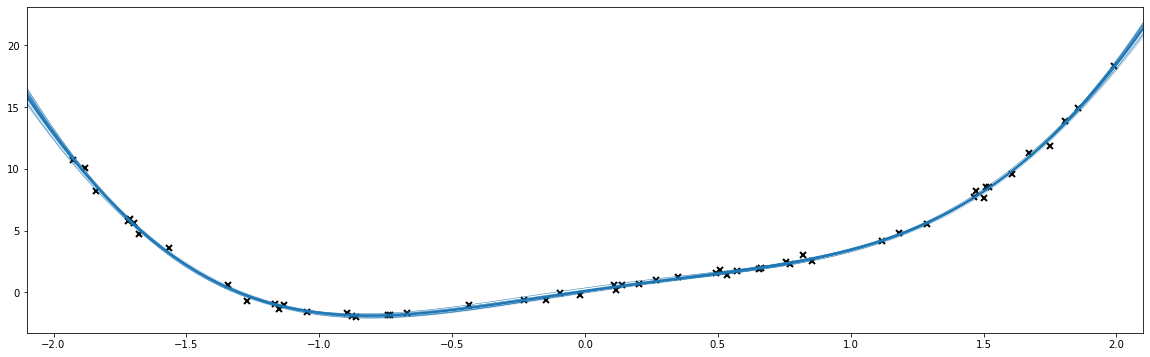

In [22]:
## generate test points for prediction
xx = np.linspace(-2.1, 2.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

## predict mean and variance of latent GP at test points
mean, var = model.predict_f(xx)

## generate 10 samples from posterior
tf.random.set_seed(1)  # for reproducibility
samples = model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

## plot
plt.figure()
plt.plot(X_sampled, Y_sampled, "kx", mew=2)
plt.plot(xx, mean, "C0", lw=2)
plt.fill_between(
    xx[:, 0],
    mean[:, 0] - 1.96 * np.sqrt(var[:, 0]),
    mean[:, 0] + 1.96 * np.sqrt(var[:, 0]),
    color="C0",
    alpha=0.2,
)
plt.plot(xx, samples[:, :, 0].numpy().T, "C0", linewidth=0.5)
#plt.plot(X, Y, color = 'darkorange', lw = 2)
_ = plt.xlim(-2.1, 2.1)

## CasADi part

In [23]:
# Package the resulting regression model in a CasADi callback
class GPR(cs.Callback):
  def __init__(self, name,  opts={}):
    cs.Callback.__init__(self)
    self.construct(name, opts)

  def eval(self, arg):
    [mean, _] = model.predict_f(np.array(arg[0]))
    return [mean.numpy()]

In [24]:
# Instantiate the Callback (make sure to keep a reference to it!)
gpr = GPR('GPR', {"enable_fd":True})
print(gpr)

GPR:(i0)->(o0) CallbackInternal


In [25]:
# Find the minimum of the regression model
x = cs.MX.sym("x")
y = 2 * gpr(x) + 5
f = cs.Function('f', [x], [y])

In [26]:
prob = {"x":x,"f":f(x)}
options = {"ipopt": {"hessian_approximation": "limited-memory", "max_iter": 500,
                     "acceptable_tol": 1e-5,
                     #"linear_solver": "ma27",
                     "acceptable_obj_change_tol": 1e-3, 
                     #"mu_strategy": "adaptive",
                     #"expect_infeasible_problem": "yes"
                    }}

In [27]:
solver = cs.nlpsol("solver","ipopt",prob, options)
res = solver(lbx = -2, ubx = 2)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equal

In [28]:
inp = tf.Variable(np.zeros((1,1)), dtype=tf.float64)

with tf.GradientTape() as tape:
    preds = model.predict_f(inp)

grads = tape.gradient(preds, inp)
grads

<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[3.15008843]])>

In [29]:
# Package the resulting regression model in a CasADi callback
class GPR_rev(cs.Callback):
    def __init__(self, name, opts={}):
        cs.Callback.__init__(self)
        
        self.refs = []
        
        self.construct(name, opts)
    
    def get_n_in(self): return 1
    def get_n_out(self): return 1
    
    def get_sparsity_in(self,i):
        return cs.Sparsity.dense(1,1)
    def get_sparsity_out(self,i):
        return cs.Sparsity.dense(1,1)


    def eval(self, arg):
        inp = np.array(arg[0])
        inp = tf.Variable(inp, dtype=tf.float64)
        [mean, _] = model.predict_f(inp)
        return [mean.numpy()]
    
    def has_reverse(self, nadj): return nadj==1
    def get_reverse(self, nadj, name, inames, onames, opts):
        grad_callback = GPR_grad(name)
        self.refs.append(grad_callback)
        
        nominal_in = self.mx_in()
        nominal_out = self.mx_out()
        adj_seed = self.mx_out()
        return cs.Function(name, nominal_in+nominal_out+adj_seed, grad_callback.call(nominal_in), inames, onames)
        
class GPR_grad(cs.Callback):
    def __init__(self, name, opts={}):
        cs.Callback.__init__(self)  
        self.construct(name, opts)
    
    def get_n_in(self): return 1
    def get_n_out(self): return 1
    
    def get_sparsity_in(self,i):
        return cs.Sparsity.dense(1,1)
    def get_sparsity_out(self,i):
        return cs.Sparsity.dense(1,1)


    def eval(self, arg):
        inp = np.array(arg[0])
        inp = tf.Variable(inp, dtype=tf.float64)
        
        with tf.GradientTape() as tape:
            preds = model.predict_f(inp)

        grads = tape.gradient(preds, inp)
        return [grads.numpy()]

In [30]:
gpr_rev = GPR_rev("gp")

In [31]:
x = cs.MX.sym("x")
y = 2 * gpr_rev(x) + 5
f = cs.Function('f', [x], [y])

In [32]:
prob = {"x":x,"f":f(x)}
options = {"ipopt": {"hessian_approximation": "limited-memory"}}

In [33]:
solver = cs.nlpsol("solver","ipopt",prob, options)
res = solver(lbx = -2, ubx = 2)

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        1
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        1
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

In [34]:
res['x']

DM(-0.812278)

In [35]:
gpr(res['x'])

DM(-1.91539)